In [1]:
import os
import csv
import sys

import pandas as pd
import numpy as np
from datetime import date, datetime

import inline as inline
import matplotlib
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [2]:
# os.environ["OMP_NUM_THREADS"] = '1'

class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class ConvAutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvAutoEncoder, self).__init__()

        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv1d(input_dim, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose1d(16, output_dim, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        # print(x.shape)
        output = self.cnn_layer1(x)
        # print(output.shape)
        output = self.cnn_layer2(output)
        # print(output.shape)
        output = self.tran_cnn_layer1(output)
        # print(output.shape)
        output = self.tran_cnn_layer2(output)
        # print(output.shape)

        return output


class k_clustering():
    def __init__(self, dataframe, dim):
        self.df = dataframe
        self.df_values = self.df.values
        self.data = torch.tensor(self.df_values, dtype=torch.float32)
        self.dim = dim

    def preprocess_with_autoencoder(self, t_sne_dim, decoder_dim=None):
        # autoencoder input dimension
        input_dim = self.data.size(1)

        # output dimension 설정
        if decoder_dim != None:
            output_dim = decoder_dim
        else:
            output_dim = self.data.size(1)

        # 모델 통과
        model = Autoencoder(input_dim, output_dim)
        output = model(self.data)
        print("autoencoder output shape:", output.shape)

        # tensor numpy로 변환
        output = output.detach().numpy()
        # print(output)

        # T-SNE로 차원 축소
        t_sne_model = TSNE(t_sne_dim)
        t_sne_output = t_sne_model.fit_transform(output)
        print("T-SNE output shape:", t_sne_output.shape)

        return t_sne_output

    def preprocess_with_conv_autoencoder(self, t_sne_dim, decoder_dim=None):
        # convolutional layer input을 위한 transpose
        transpose_input = torch.transpose(self.data, 1, 0)
        input_dim = transpose_input.size(0)

        # 추후 최적화 때 실험할 output dimension 설정
        if decoder_dim != None:
            output_dim = decoder_dim
        else:
            output_dim = transpose_input.size(0)

        # 모델 통과
        model = ConvAutoEncoder(input_dim, output_dim)
        decoded = model(transpose_input)
        transpose_output = torch.transpose(decoded, 1, 0)
        print("Conv Autoencoder output shape:", transpose_output.shape)

        # Numpy 변환
        transpose_output = transpose_output.detach().numpy()

        # output dimension for T-SNE
        t_sne_model = TSNE(t_sne_dim)
        t_sne_output = t_sne_model.fit_transform(transpose_output)
        print("T-SNE output shape:", t_sne_output.shape)

        return t_sne_output

    def k_means_clustering(self, num_cluster, autoencoder_type):
        clustering_input = None
        if str(autoencoder_type) == ("linear" or "Linear"):
            clustering_input = self.preprocess_with_autoencoder(2)
        elif str(autoencoder_type) == ("conv" or "Conv"):
            clustering_input = self.preprocess_with_conv_autoencoder(2)
        else:
            assert autoencoder_type == "linear" or autoencoder_type == "conv"

        print("Clustering input dimension:", clustering_input.shape)

        k_means = KMeans(init="k-means++", n_clusters=num_cluster, random_state = 1)
        k_means.fit(clustering_input)
        cluster = k_means.predict(clustering_input)
        labels = k_means.labels_
        centers = k_means.cluster_centers_

        # Medoid 찾기
        closest, distances = vq(centers, clustering_input)
        print("Closest Medoid Indexs are", closest)

        # 2차원인 경우 그래프 그리기
        if clustering_input.shape[1] == 2:
            fig = plt.figure(figsize=(6, 4))
            colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
            graph = fig.add_subplot(1, 1, 1)

            for k, col, close_idx in zip(range(6), colors, closest):
                my_members = (labels == k)
                if my_members[close_idx] == True:
                    graph.plot(clustering_input[close_idx, 0], clustering_input[close_idx, 1], markerfacecolor=col,
                               marker='h', markeredgecolor='b', markersize=20)
                graph.plot(clustering_input[my_members, 0], clustering_input[my_members, 1], linestyle='None', mec='k',
                           mew=0.5, markerfacecolor=col, marker='o', markersize=5)
                # graph.plot(input_data[close_center, 0], input_data[close_center, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=20)

            graph.set_title('K-Means')
            graph.set_xticks(())
            graph.set_yticks(())
            plt.show()

        return labels, closest

    # 실루엣 지수로 최적화
    def optimize_clustering(self, autoencoder_type):
        clustering_input = None
        if str(autoencoder_type) == ("linear" or "Linear"):
            clustering_input = self.preprocess_with_autoencoder(2)
        elif str(autoencoder_type) == ("conv" or "Conv"):
            clustering_input = self.preprocess_with_conv_autoencoder(2)
        else:
            assert autoencoder_type == "linear" or autoencoder_type == "conv"

        print("Clustering input dimension:", clustering_input.shape)

        best_num_cluster = 0
        best_silhouette_score = -1
        k_range = range(4, 13)

        inertia_list = []

        for k in k_range:
            # k_means = MiniBatchKMeans(init="k-means++", n_clusters=k, n_init=5, random_state = 1, batch_size=5)
            k_means = KMeans(init="k-means++", n_clusters=k, random_state=1)
            k_means.fit(clustering_input)
            cluster = k_means.predict(clustering_input)

            # silhouette score calculation
            score = silhouette_score(clustering_input, cluster)
            print('k:', k, "silhouette score:", score)

            inertia = k_means.inertia_
            inertia_list.append(inertia)

            if score > best_silhouette_score:
                best_num_cluster = k
                best_silhouette_score = score

        print("Best number of clusters:", best_num_cluster, "Score:", best_silhouette_score)

        return best_num_cluster

Reduced Dimension: 2
Conv Autoencoder output shape: torch.Size([7348, 56])


C:\Users\reiss\conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\reiss\conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (7348, 2)
Clustering input dimension: (7348, 2)
k: 4 silhouette score: 0.61087185
k: 5 silhouette score: 0.545014
k: 6 silhouette score: 0.5017917
k: 7 silhouette score: 0.43974397
k: 8 silhouette score: 0.39813215
k: 9 silhouette score: 0.39918748
k: 10 silhouette score: 0.40088677
k: 11 silhouette score: 0.4012799
k: 12 silhouette score: 0.39531463
Best number of clusters: 4 Score: 0.61087185
Reduced Dimension: 3
Conv Autoencoder output shape: torch.Size([7348, 56])


C:\Users\reiss\conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\reiss\conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (7348, 2)
Clustering input dimension: (7348, 2)
k: 4 silhouette score: 0.5632311
k: 5 silhouette score: 0.5409228
k: 6 silhouette score: 0.4980565
k: 7 silhouette score: 0.47201964
k: 8 silhouette score: 0.43660665
k: 9 silhouette score: 0.4423826
k: 10 silhouette score: 0.43557465
k: 11 silhouette score: 0.42089275
k: 12 silhouette score: 0.39719588
Best number of clusters: 4 Score: 0.5632311
Conv Autoencoder output shape: torch.Size([7348, 56])


C:\Users\reiss\conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\reiss\conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (7348, 2)
Clustering input dimension: (7348, 2)
Closest Medoid Indexs are [ 905   52 2127 2306]


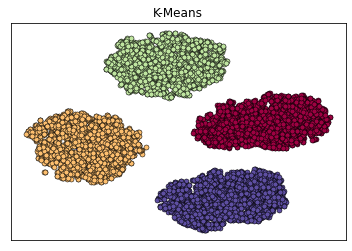

--- 139.19685983657837 seconds ---


In [3]:
if __name__ == '__main__':
    start_time = time.time()

    df = pd.read_csv('본선_data_final.csv')
    df = df.iloc[:, 1:]
    dims = [2, 3]
    for dim in dims:
        print("Reduced Dimension:", dim)
        model = k_clustering(df, dim)
        # parameter = "linear" or "conv"
        optimal_num_cluster = model.optimize_clustering('conv')
        # optimal_num_cluster = 4
        # model.k_means_clustering(optimal_num_cluster, "conv")

    df = pd.read_csv('본선_data_final.csv')
    df = df.iloc[:, 1:]
    model = k_clustering(df, 2)
    # parameter = "linear" or "conv"
    # optimal_num_cluster = model.optimize_clustering('conv')
    optimal_num_cluster = 4
    labels, medoids = model.k_means_clustering(optimal_num_cluster, "conv")

    print("--- %s seconds ---" % (time.time() - start_time))